# 1.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import scipy as sp
import cv2
import os
import sys
#suppress warnings for cleanliness
import warnings
warnings.filterwarnings('ignore')

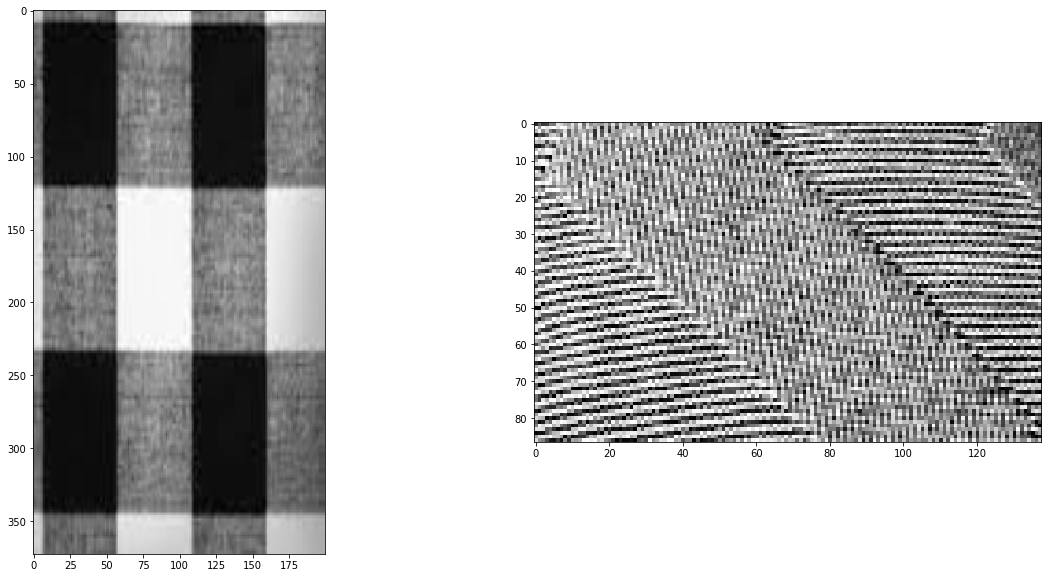

In [67]:
flower = "texture2.jpg"
leaf   = "texture1.jpg"

imgtex1 = cv2.imread(flower)
imgtex2 = cv2.imread(leaf)
imgtex1 = cv2.cvtColor(imgtex1, cv2.COLOR_BGR2GRAY)
imgtex2 = cv2.cvtColor(imgtex2, cv2.COLOR_BGR2GRAY)
imgtex1 = cv2.resize(imgtex1, (200,373))
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(imgtex1, cmap="gray")
plt.subplot(122)
plt.imshow(imgtex2, cmap="gray")

In [68]:
#blur
blurred1 = cv2.GaussianBlur(imgtex1, (5,5), 1.5)
blurred2 = cv2.GaussianBlur(imgtex2, (5,5), 1.5)

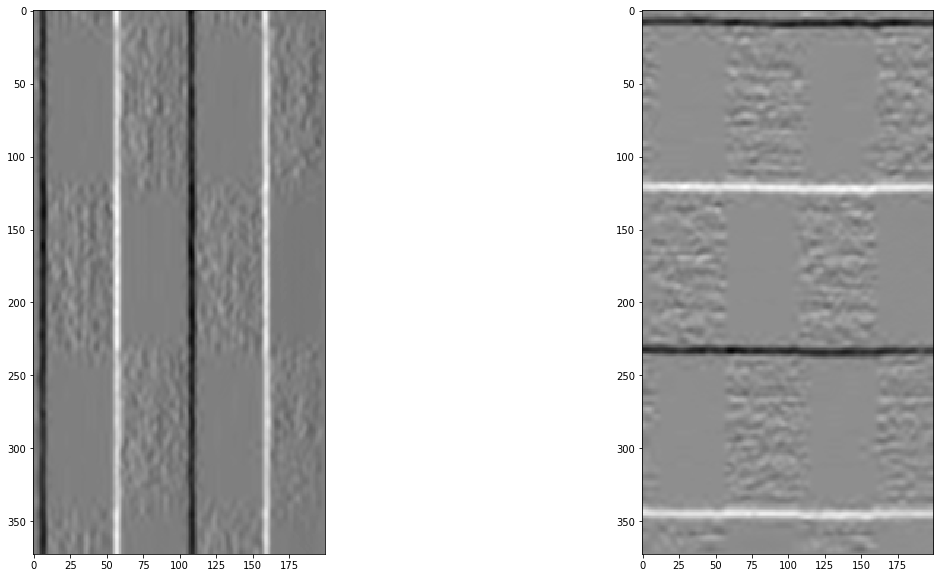

In [69]:
sobelx = cv2.Sobel(blurred1,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(blurred1,cv2.CV_64F,0,1,ksize=5)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(sobelx, cmap="gray")
plt.subplot(122)
plt.imshow(sobely, cmap="gray")

In [70]:
shape = sobelx.shape + (2,)
A_1 = np.zeros(shape)

for i in range(shape[0]):
    for j in range(shape[1]):
        A_1[i][j][0]=sobelx[i][j]
        A_1[i][j][1]=sobely[i][j]
        

In [71]:
shape = sobelx.shape + (2,2)
B_1 = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        B_1[i][j] = np.matmul(A_1[i][j], A_1[i][j].T)
        
def avg(matrix, i, j):
    C = np.zeros((2,2))
    counter = 0
    for i in range(max(i-2, 0), min(i+2, matrix.shape[0]-1)):
        for j in range(max(j-2, 0), min(j+2, matrix.shape[1]-1)):
#             print(i, j)
            C = C + matrix[i][j]
            counter = counter + 1
    C = C/counter
    return C
    
N = np.zeros(shape)
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        N[i][j] = avg(B_1, i, j)
        
D = []
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        D.append(N[i][j])

In [81]:
#defining loss functions
from scipy import linalg
def forb_loss(mat1, mat2):
    diff = mat1 - mat2
    A = np.square(diff)
    return np.sqrt(np.sum(A))

def max_col_sums(mat1, mat2):
    diff = mat1-mat2
    diff = np.absolute(diff)
    maxcol = 0
    for i in range(diff.shape[1]):
        colsum = diff.sum(axis=0)
        if np.sum(colsum) > maxcol:
            maxcol = np.sum(colsum)
    return maxcol

def stein_loss(mat1, mat2):
    d = 10000
    try:
        choleskyA = np.linalg.cholesky(np.absolute(mat1) + np.identity(2))
        choleskyB = np.linalg.cholesky(np.absolute(mat2) + np.identity(2))
        choleskyAB = np.linalg.cholesky(np.absolute((mat1 + mat2)/2) + np.identity(2))
        d = 2* np.log(np.linalg.det(choleskyAB)) - np.log(np.linalg.det(choleskyA)) -np.log(np.linalg.det(choleskyB)) 
        return d
    except:
        return d


In [51]:
#My own k means

import random

metrics = [forb_loss, max_col_sums, stein_loss]
clusters_imgs = [np.zeros(imgtex1.shape), np.zeros(imgtex1.shape), np.zeros(imgtex1.shape)]
clusters = 2
iterations = 5

def color(cluster_count, k):
    return 250 * k/cluster_count

def recompute(cluster_centers, cluster_members):
    
    cont = 0
    for group in cluster_members:
        craw = np.zeros((2,2))
        counter = 0
        for item in group:
            craw = item + craw
            counter = counter + 1
        craw = craw/counter
        cluster_centers[cont] = craw
        cont = cont + 1
    return cluster_centers

clus_count = 0
for metric in metrics:
    #init
    cluster_centers = []
    cluster_centers_size = np.ones(clusters)
    cluster_members = np.empty((clusters, 0)).tolist()

    for k in range(clusters):
        i_rand = random.randint(0, imgtex1.shape[0])
        j_rand = random.randint(0, imgtex1.shape[1])
        cluster_centers.append(N[i_rand][j_rand])
        cluster_members[k].append(N[i_rand][j_rand])
    for it in range(iterations):
        for i in range(N.shape[0]):
            #starting iteration
            for j in range(N.shape[1]):
                shortest = 0
                short_dist = 1073741823
                for k in range(len(cluster_centers)):
                    d = metric(N[i][j], cluster_centers[k])
                    if d <= short_dist:
                        shortest = k
                        short_dist = d
                clusters_imgs[clus_count][i][j] = color(clusters, shortest)
                cluster_members[shortest].append(N[i][j])
            #recompute means after iteration
            cluster_centers = recompute(cluster_centers, cluster_members)
            cluster_members = np.empty((clusters, 0)).tolist()
    clus_count = clus_count + 1

print("Clustering for forbloss finished")




17 55
253 21
Cluster center shape (2, 2, 2)
40 127
190 130
Cluster center shape (2, 2, 2)
237 165
258 45
Cluster center shape (2, 2, 2)
Clustering for forbloss finished


Iterations =  5
Clusters =  2


Text(0.5, 1.0, 'Stein Loss')

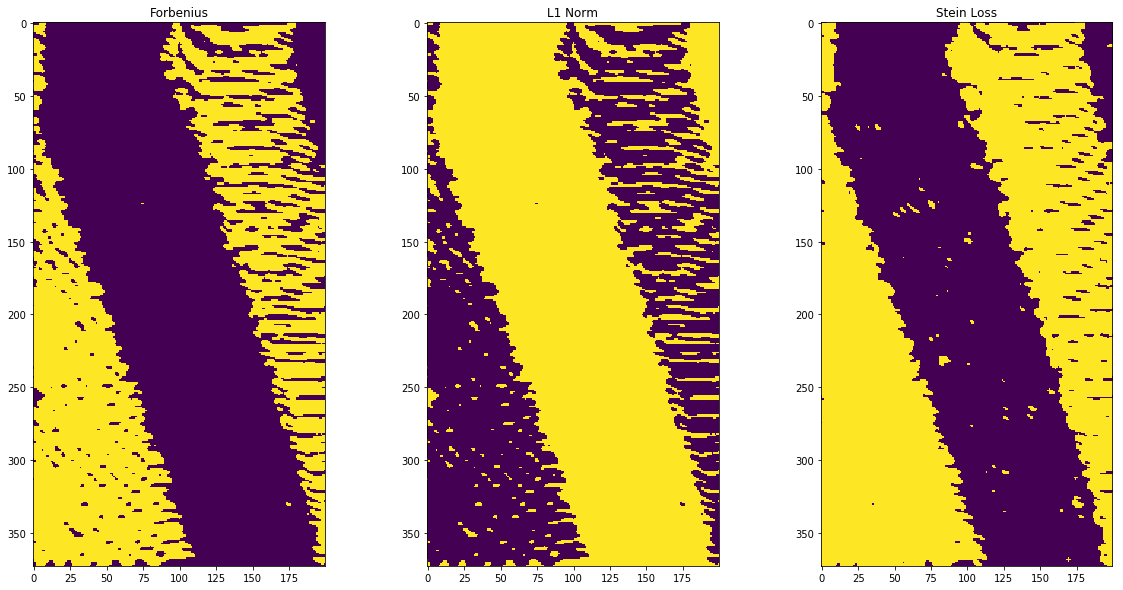

In [53]:
print("Iterations = ", iterations)
print("Clusters = ", clusters)
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(clusters_imgs[0])
plt.title("Forbenius")
plt.subplot(132)
plt.imshow(clusters_imgs[1])
plt.title("L1 Norm")
plt.subplot(133)
plt.imshow(clusters_imgs[2])
plt.title("Stein Loss")

In [65]:
metrics = [forb_loss, max_col_sums, stein_loss]
clusters_imgs = [np.zeros(imgtex1.shape), np.zeros(imgtex1.shape), np.zeros(imgtex1.shape)]
clusters = 3
iterations = 5
clus_count = 0
for metric in metrics:
    #init
    cluster_centers = []
    cluster_centers_size = np.ones(clusters)
    cluster_members = np.empty((clusters, 0)).tolist()

    for k in range(clusters):
        i_rand = random.randint(0, imgtex1.shape[0])
        j_rand = random.randint(0, imgtex1.shape[1])
        cluster_centers.append(N[i_rand][j_rand])
        cluster_members[k].append(N[i_rand][j_rand])
    for it in range(iterations):
        for i in range(N.shape[0]):
            #starting iteration
            for j in range(N.shape[1]):
                shortest = 0
                short_dist = 1073741823
                for k in range(len(cluster_centers)):
                    d = metric(N[i][j], cluster_centers[k])
                    if d <= short_dist:
                        shortest = k
                        short_dist = d
                clusters_imgs[clus_count][i][j] = color(clusters, shortest)
                cluster_members[shortest].append(N[i][j])
            #recompute means after iteration
            cluster_centers = recompute(cluster_centers, cluster_members)
            cluster_members = np.empty((clusters, 0)).tolist()
    clus_count = clus_count + 1

print("Clustering for forbloss finished")

Clustering for forbloss finished


Iterations =  5
Clusters =  3


Text(0.5, 1.0, 'Stein Loss')

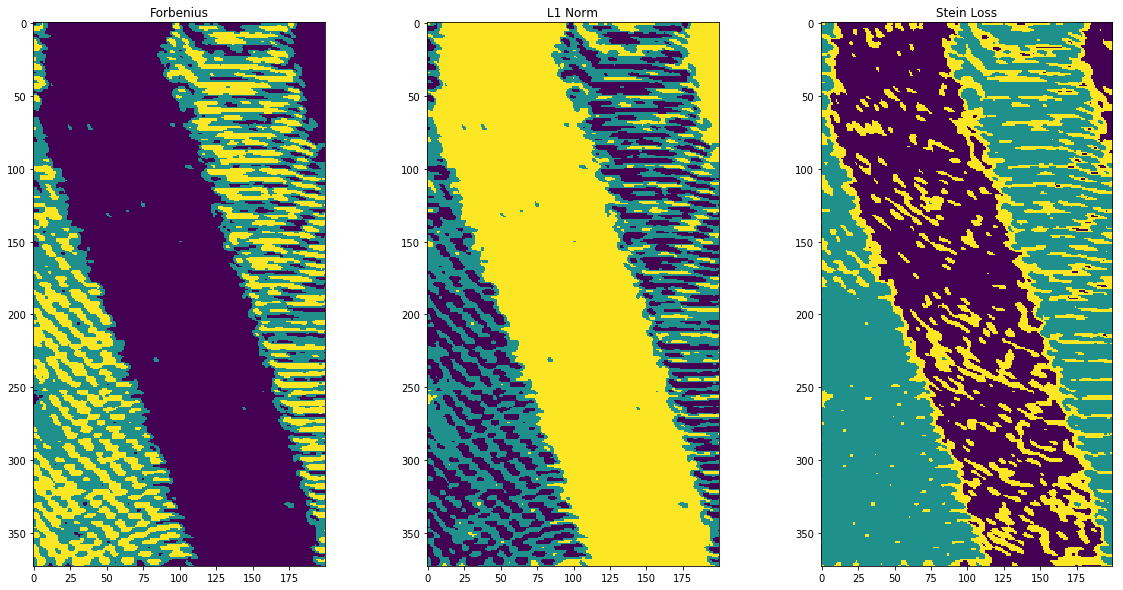

In [66]:
print("Iterations = ", iterations)
print("Clusters = ", clusters)
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(clusters_imgs[0])
plt.title("Forbenius")
plt.subplot(132)
plt.imshow(clusters_imgs[1])
plt.title("L1 Norm")
plt.subplot(133)
plt.imshow(clusters_imgs[2])
plt.title("Stein Loss")

In [82]:
metrics = [forb_loss, max_col_sums, stein_loss]
clusters_imgs = [np.zeros(imgtex1.shape), np.zeros(imgtex1.shape), np.zeros(imgtex1.shape)]
clusters = 2
iterations = 5
clus_count = 0
for metric in metrics:
    #init
    cluster_centers = []
    cluster_centers_size = np.ones(clusters)
    cluster_members = np.empty((clusters, 0)).tolist()

    for k in range(clusters):
        i_rand = random.randint(0, imgtex1.shape[0])
        j_rand = random.randint(0, imgtex1.shape[1])
        cluster_centers.append(N[i_rand][j_rand])
        cluster_members[k].append(N[i_rand][j_rand])
    for it in range(iterations):
        for i in range(N.shape[0]):
            #starting iteration
            for j in range(N.shape[1]):
                shortest = 0
                short_dist = 1073741823
                for k in range(len(cluster_centers)):
                    d = metric(N[i][j], cluster_centers[k])
                    if d <= short_dist:
                        shortest = k
                        short_dist = d
                clusters_imgs[clus_count][i][j] = color(clusters, shortest)
                cluster_members[shortest].append(N[i][j])
            #recompute means after iteration
            cluster_centers = recompute(cluster_centers, cluster_members)
            cluster_members = np.empty((clusters, 0)).tolist()
    clus_count = clus_count + 1

print("Clustering for forbloss finished")

Clustering for forbloss finished


Iterations =  5
Clusters =  2


Text(0.5, 1.0, 'Stein Loss')

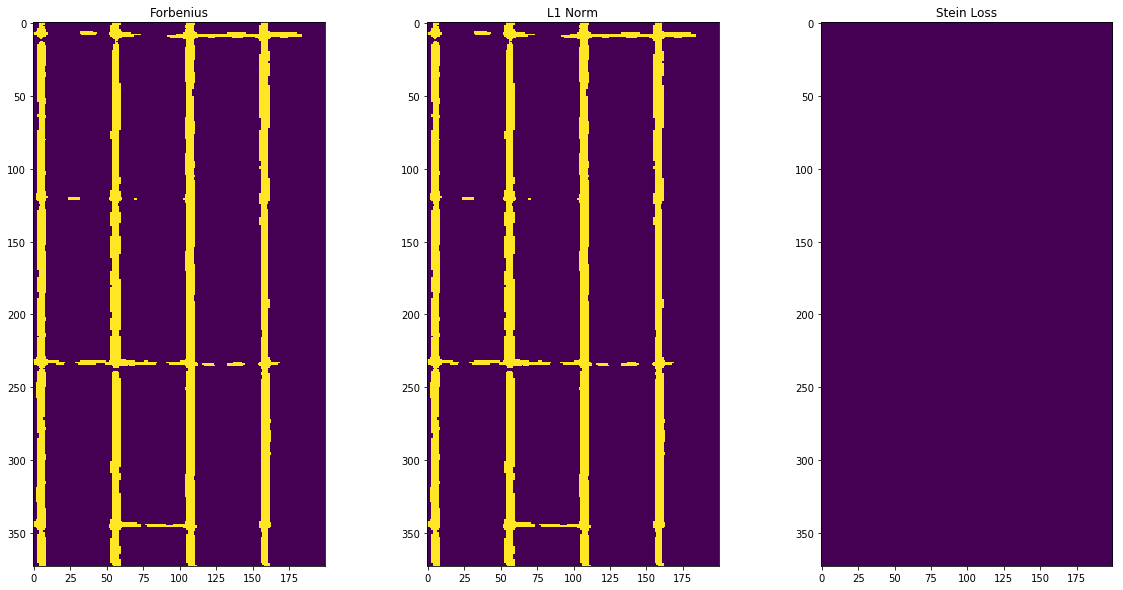

In [83]:
print("Iterations = ", iterations)
print("Clusters = ", clusters)
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(clusters_imgs[0])
plt.title("Forbenius")
plt.subplot(132)
plt.imshow(clusters_imgs[1])
plt.title("L1 Norm")
plt.subplot(133)
plt.imshow(clusters_imgs[2])
plt.title("Stein Loss")

In [84]:
metrics = [forb_loss, max_col_sums, stein_loss]
clusters_imgs = [np.zeros(imgtex1.shape), np.zeros(imgtex1.shape), np.zeros(imgtex1.shape)]
clusters = 3
iterations = 5
clus_count = 0
for metric in metrics:
    #init
    cluster_centers = []
    cluster_centers_size = np.ones(clusters)
    cluster_members = np.empty((clusters, 0)).tolist()

    for k in range(clusters):
        i_rand = random.randint(0, imgtex1.shape[0])
        j_rand = random.randint(0, imgtex1.shape[1])
        cluster_centers.append(N[i_rand][j_rand])
        cluster_members[k].append(N[i_rand][j_rand])
    for it in range(iterations):
        for i in range(N.shape[0]):
            #starting iteration
            for j in range(N.shape[1]):
                shortest = 0
                short_dist = 1073741823
                for k in range(len(cluster_centers)):
                    d = metric(N[i][j], cluster_centers[k])
                    if d <= short_dist:
                        shortest = k
                        short_dist = d
                clusters_imgs[clus_count][i][j] = color(clusters, shortest)
                cluster_members[shortest].append(N[i][j])
            #recompute means after iteration
            cluster_centers = recompute(cluster_centers, cluster_members)
            cluster_members = np.empty((clusters, 0)).tolist()
    clus_count = clus_count + 1

print("Clustering for forbloss finished")

Clustering for forbloss finished


Iterations =  5
Clusters =  3


Text(0.5, 1.0, 'Stein Loss')

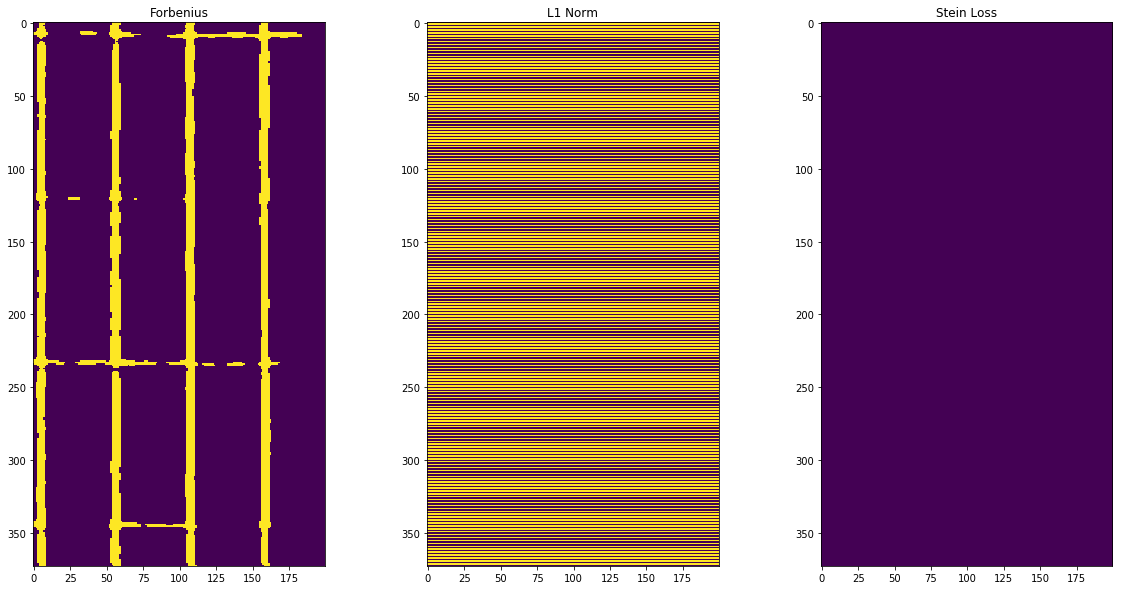

In [85]:
print("Iterations = ", iterations)
print("Clusters = ", clusters)
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(clusters_imgs[0])
plt.title("Forbenius")
plt.subplot(132)
plt.imshow(clusters_imgs[1])
plt.title("L1 Norm")
plt.subplot(133)
plt.imshow(clusters_imgs[2])
plt.title("Stein Loss")

# 2.

(400, 112, 92)
[[ 41.  43.  63. ... 125. 119. 125.]
 [ 47.  50.  53. ... 119. 120. 124.]
 [ 47.  41.  35. ... 124. 120. 124.]
 ...
 [ 35. 158.  41. ...  36.  89.  36.]
 [ 37. 153.  10. ...  39.  94.  35.]
 [ 38. 169.  24. ...  40.  85.  34.]]


KeyboardInterrupt: 